# Overview


- **2.0. Recap**
  - 2.0.1. *Perceptron*
  - 2.0.2. *Gradient Descent*
  - 2.0.3. *Training with PyTorch*
<br><br>

- **2.1. Autograd**
  - 2.1.1. *NN from Scratch*
  - 2.1.2. *Autograd with `loss.backward()`*
  - 2.1.3. *Forward propagation with `nn.Module`*
  - 2.1.4. *Parameter updates with `torch.optim`*
<br><br>

- **2.2. Activation Functions**
  - 2.2.1. *Sigmoid*
  - 2.2.2. *Other S-Shaped Activations*
  - 2.2.3. *More Activations*
  - 2.2.4. *Activation with PyTorch*
<br><br>

<!--
- **2.3. Loss Functions**
  - 2.3.1. *L1 Loss (MAE) and L2 Loss (MSE)*
  - 2.3.2. *Negative Log Likelihood* 
  - 2.3.3. *Cross-Entropy*
<br><br>

- **2.4. Optimizers**
  - 2.4.1. *Gradient Descent*
  - 2.4.2. *Stochastic Gradient Descent*
  - 2.4.3. *Adam*
  - 2.4.4. *Learning Rate Scheduler*
<br><br>
-->

In [1]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import clear_output

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

## 2.0.1.  Perceptron (Recap)


Given a set of inputs $x$, the perceptron 

 - learns $w$ tensor to map the inputs to a real-value output between $[0,1]$
 - through the summation of the dot product of the $w·x$ 
 - with a transformation function (aka. activation function), e.g. sigmoid function
 
 
### In Math:

$ \ \ \ \ \ \ \ \ \ sigmoid(s) = 1 / (1+e^{-s})$

$ \ \ \ \ \ \ \ \ \ perceptron(x) = sigmoid(\sum_{ 1 }^{ n }{w \cdot x})$

where $n$ is the no. of inputs.

### In Picture:

In [377]:
Image(url="https://ibin.co/4TyMU8AdpV4J.png", width=500)

(**Note:** Usually, we use $x_1$ as the bias and fix the input to 1)

# 2.0.2. Gradient Descent (Recap)

To learn the $w$ tensor, **gradient descent methods**, e.g. stochastic gradient descent (SGD) or SGD with momentum (Adam) is used to 

 - minimize the loss/difference between 
 - $y$: the desired truth value given the same $x$ inputs and 
 - $\hat{y}$: the output of the perceptron


#### Mean Absolute Loss (L1 Loss):

$ \ \ \ \ \ \ \ \ \ mae = \frac { 1 }{ m }  \sum_{ 1 }^{ m }{|y-\hat{y}|}$



#### Mean Square Loss (L2 Loss):

$ \ \ \ \ \ \ \ \ \ mse = \frac { 1 }{ m } \sum_{ 1 }^{ m }{(y-\hat{y})^2}$

where $m$ is the no. of predictions made by the perceptron.

# 2.0.3. Training Multi-Layered Perceptron with PyTorch

To train a model using PyTorch, we simply iterate through the no. of epochs and imperatively state the computations we want to perform. 

## Remember the steps?

 1. Initialize 
   - model and its layers, hidden dimensions and activation functions.
   - optimizers and its learning rate
   - loss function
   - stopping criteria
 2. Forward Propagation
 3. Backward Propagation
 4. Update Optimizer

In [9]:
!pip3 install tqdm


    100% |████████████████████████████████| 51kB 1.7MB/s ta 0:00:01
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch import tensor
from torch import optim

import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# XOR gate inputs and outputs.
X = xor_input = tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = tensor([[0],[1],[1],[0]]).float().to(device)

# Use tensor.shape to get the shape of the matrix/tensor.
num_data, input_dim = X.shape
print('Inputs Dim:', input_dim) # i.e. n=2 

num_data, output_dim = Y.shape
print('Output Dim:', output_dim) 
print('No. of Data:', num_data) # i.e. n=4

Inputs Dim: 2
Output Dim: 1
No. of Data: 4


100%|██████████| 5000/5000 [00:02<00:00, 1873.84it/s]


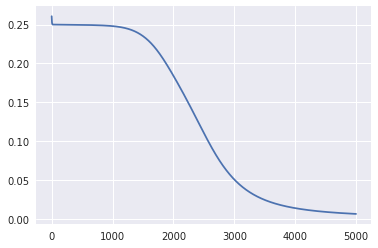

In [13]:
# Step 1: Initialization. 

# Initialize the model.
# Set the hidden dimension size.
hidden_dim = 10
# Use Sequential to define a simple feed-forward network.
model = nn.Sequential(
            # Use nn.Linear to get our simple perceptron.
            nn.Linear(input_dim, hidden_dim),
            # Use nn.Sigmoid to get our sigmoid non-linearity.
            nn.Sigmoid(),
            # Second layer neurons.
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

# Initialize the optimizer
learning_rate = 0.3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Initialize the loss function.
criterion = nn.MSELoss()

# Initialize the stopping criteria
# For simplicity, just stop training after certain no. of epochs.
num_epochs = 5000 

losses = [] # Keeps track of the loses.

# Step 2-4 of training routine.

for _e in tqdm(range(num_epochs)):
    # Reset the gradient after every epoch. 
    optimizer.zero_grad() 
    # Step 2: Foward Propagation
    predictions = model(X)
    
    # Step 3: Back Propagation 
    # Calculate the cost between the predictions and the truth.
    loss = criterion(predictions, Y)
    # Remember to back propagate the loss you've computed above.
    loss.backward()
    
    # Step 4: Optimizer take a step and update the weights.
    optimizer.step()
    
    # Log the loss value as we proceed through the epochs.
    losses.append(loss.data.item())
    

plt.plot(losses)

# 2.1. Autograd

In this section, we'll see how PyTorch does the `loss.backward()` and `optimizer.step()` behind the scenes.


## 2.1.1. NN from Scratch 

Before that lets relive the pains of coding neural nets from scratch (with `numpy`)...

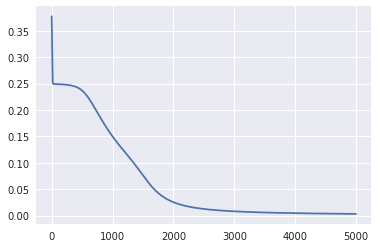

In [14]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

def sigmoid(x): # Returns values that sums to one.
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(sx):
    # See https://math.stackexchange.com/a/1225116
    return sx * (1 - sx)

# Cost functions.
def mse(predicted, truth):
    return np.square(predicted - truth).mean()

def mse_derivative(predicted, truth):
    # See https://math.stackexchange.com/a/1962938/34255
    return 2 * (predicted - truth)

X = xor_input = np.array([[0,0], [0,1], [1,0], [1,1]])
Y = xor_output = np.array([[0,1,1,0]]).T

# Define the shape of the weight vector.
num_data, input_dim = X.shape
# Lets set the dimensions for the intermediate layer.
hidden_dim = 5
# Initialize weights between the input layers and the hidden layer.
W1 = np.random.random((input_dim, hidden_dim))

# Define the shape of the output vector. 
output_dim = len(Y.T)
# Initialize weights between the hidden layers and the output layer.
W2 = np.random.random((hidden_dim, output_dim))

# Initialize weigh
num_epochs = 5000
learning_rate = 0.15

losses = []

for epoch_n in range(num_epochs):
    layer0 = X
    # Forward propagation.
    
    # Inside the perceptron, Step 2. 
    layer1 = sigmoid(np.dot(layer0, W1))
    layer2 = sigmoid(np.dot(layer1, W2))

    # Back propagation (Y -> layer2)
    # How much did we miss in the predictions?
    cost_error = mse(layer2, Y)
    
    # In what direction is the target value?
    # Were we really close? If so, don't change too much.
    layer2_error = mse_derivative(layer2, Y)
    layer2_delta = layer2_error *  sigmoid_derivative(layer2)
    
    # Back propagation (layer2 -> layer1)
    # How much did each layer1 value contribute to the layer2 error (according to the weights)?
    layer1_error = np.dot(layer2_delta, W2.T)
    layer1_delta = layer1_error * sigmoid_derivative(layer1)
    
    # update weights
    W2 += - learning_rate * np.dot(layer1.T, layer2_delta)
    W1 += - learning_rate * np.dot(layer0.T, layer1_delta)
    #print(np.dot(layer0.T, layer1_delta))
    #print(epoch_n, list((layer2)))
    
    # Log the loss value as we proceed through the epochs.
    losses.append(cost_error)
    #print(cost_delta)

    
# Visualize the losses
plt.plot(losses)
plt.show()

## 2.1.2. Autograd with `loss.backward()`

The nice thing about the `loss.backward()` function is that it does automatic gradient backpropagation and **we don't have to go through the multiple dot products on layer errors and deltas** =)

To do so lets use

 - `torch.tensor()` objects to initialize X and Y.
 - `torch.randn()` objects to initialize the W1 and W2
 - `torch.exp` and `torch.mean` to replace the numpy functions.


100%|██████████| 10000/10000 [00:07<00:00, 1318.10it/s]


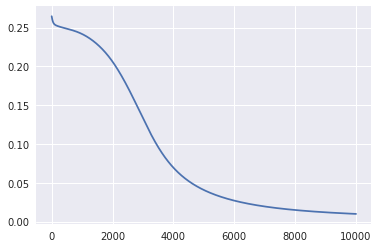

In [16]:
def sigmoid(x): # Returns values that sums to one.
    return 1 / (1 + torch.exp(-x))

# Cost functions.
def mse(predicted, truth):
    return torch.mean((predicted - truth)**2)

X = xor_input = torch.tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = torch.tensor([[0], [1], [1], [0]]).float().to(device)

# Define the shape of the weight vector.
num_data, input_dim = X.shape
hidden_dim = 5
output_dim = len(Y)
# When we initialize tensors that needs updating, we use `require_grad=True` 
# for autograd to kick in later on.
W1 = torch.randn(input_dim, hidden_dim, requires_grad=True).to(device)
W2 = torch.randn(hidden_dim, output_dim, requires_grad=True).to(device)


num_epochs = 10000
learning_rate = 0.3

losses = []

for epoch_n in tqdm(range(num_epochs)):
    layer0 = X
    # See https://pytorch.org/docs/stable/torch.html#torch.mm
    # Use the torch.tensor.mm() instead of np.dot()
    layer1 = sigmoid(X.mm(W1))
    layer2 = sigmoid(layer1.mm(W2))

    # Loss is a Tensor of torch.Size([]), so and loss.item() is a scalar/float.
    # Try printing `print(loss.shape)` to confirm the above.
    loss = mse(layer2, Y)
    # Keep track of the losses.
    losses.append(loss.item())
    
    # The `loss.backward()` will compute the gradient of loss w.r.t. all
    # tensors that has `requires_grad=True`.
    # After this, W1.grad and W2.grad will hold the gradients of 
    # the loss w.r.t. to W1 and W2 respectively.
    loss.backward()
    
    # Now we have the backpropagated gradients, we want to update the weights.
    # Whenever you perform tensor operations on tensors that has `requires_grad=True`,
    # pytorch will try to build computation graph. For now, we only need to 
    # force the updates of our weights without forming more computation graph,
    # so we use the no_grad() context manager:
    with torch.no_grad():
        W1 += -learning_rate * W1.grad
        W2 += -learning_rate * W2.grad
        
    # Manually zero the gradients after running the backward pass.
    # Every epoch our graphs needs to be re-computed. 
    W1.grad.zero_()
    W2.grad.zero_()

# Visualize the losses
plt.plot(losses)
plt.show()

### Play around with the code above

 - See what's the gradient values after `loss.backward()`, **print out `W1.grad` and `W2.grad`** 
 <br><br>
 - Check **what happens when you don't have `torch.no_grad()`** context manager, (hint: pytorch will complain)
 <br><br>
 - **What happens when you don't zero the gradients?** How will it affect the loss? 
 <br><br>
 - Note that in both the sigmoid and the MSE function, **we didn't declare any derivatives** 
   - the `torch.autograd` module has helped do the grunt work of computing backpropagation
   - It's out of scope for this course to create custom `backward()` autograd function, but I'll leave you with [this tutorial](https://github.com/jcjohnson/pytorch-examples#pytorch-defining-new-autograd-functions)
 

## 2.1.3. Forward Propagation with `nn.Module`

Now that we know how the backpropagation is automated with autograd, we should have similar mechanism when we declare a complicated neural network and forward propagate too. The `nn` package in PyTorch serves this purpose.

An `nn.Module` receive input tensors and compute the output tensor. Depending on the `nn.Module` type, it might also hold learnable weights/parameters tensors.

Previously we were declaring the network and initialize the learnable weights/parameters in a raw manner:

```python
X = xor_input = torch.tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = torch.tensor([[0], [1], [1], [0]]).float().to(device)

num_data, input_dim = X.shape
hidden_dim = 5
output_dim = len(Y)

W1 = torch.randn(input_dim, hidden_dim, requires_grad=True).to(device)
W2 = torch.randn(hidden_dim, output_dim, requires_grad=True).to(device)
```

Then we had to apply the layers and activation manually during the training routine:

```python
for epoch_n in tqdm(range(num_epochs)):
    layer0 = X
    layer1 = sigmoid(X.mm(W1))
    layer2 = sigmoid(layer1.mm(W2))

```

Instead of doing that we can define our model as a sequence of layers with `nn.Sequential(...)`, e.g. 

```python

model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_dim),
          torch.nn.Sigmoid(),
          torch.nn.Linear(hidden_dim, output_dim),
          torch.nn.Sigmoid()
        )

```

And even the loss function can be a `nn.Module`, e.g. 

```python
criterion = nn.MSELoss()
```

And forward propagation would be simply this:


In [19]:
X = xor_input = torch.tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = torch.tensor([[0], [1], [1], [0]]).float().to(device)

# Define the shape of the weight vector.
num_data, input_dim = X.shape
hidden_dim = 5
output_dim = len(Y)

# Initialize the network as an nn.Sequential.
model = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.Sigmoid(),
          nn.Linear(hidden_dim, output_dim),
          nn.Sigmoid()
        ).to(device)

# Declare the loss function as an nn.Module.
criterion = nn.MSELoss()

num_epochs = 10000
learning_rate = 0.3

losses = []

for epoch_n in tqdm(range(num_epochs)):
    # Forward propagation.
    predictions = model(X)
    # Compute Loss
    loss = criterion(predictions, Y)
    # Keep track of the losses.
    losses.append(loss.item())
    
    # Backpropagation.
    loss.backward()
    
    # Instead of manually coding which weight tensors to update,
    # we iterate through all the layers in the model, and update 
    # the parameters by access the backpropdated gradients respectively.
    with torch.no_grad():
        for param in model.parameters():
            # Remember each parameter keeps their own .grad tensors after loss.backward()
            param.data += -learning_rate * param.grad
        
    # Zero the gradients after running the backward pass, 
    # the nn.Sequential will automatically go to each learnable parameter
    # to zero its gradient.
    model.???()

# Visualize the losses
plt.plot(losses)
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]


AttributeError: 'Sequential' object has no attribute 'zero'

## 2.1.4. Parameter updates with `torch.optim`

Updating the weights is the last step to automating the backpropagation and weights updates. For this, the `torch.optim` package handles the learning rate updates that we've been doing manually, i.e. 

```python
with torch.no_grad():
    for param in model.parameters():
        param.data += -learning_rate * param.grad
```

We use the objects in the `torch.optim` module to initialize the optimizer objects that will help hold the gradients updates according to the `model.parameters()` it's initialized with. E.g. 


100%|██████████| 10000/10000 [00:03<00:00, 2539.97it/s]


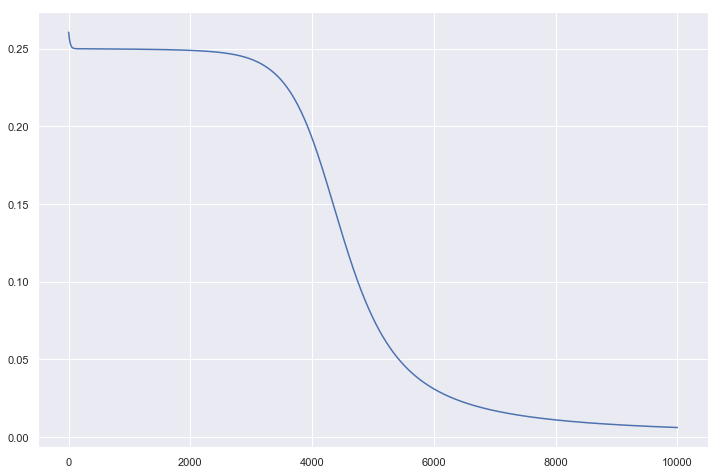

In [383]:
# Initialize the network as an nn.Sequential.
model = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.Sigmoid(),
          nn.Linear(hidden_dim, output_dim),
          nn.Sigmoid()
        ).to(device)

# Declare the loss function as an nn.Module.
criterion = nn.MSELoss()

num_epochs = 10000
learning_rate = 0.3

# Initialize the optimizer that'll help us with the parameters updates.
optimizer = torch.optim.SGD(model.???(), lr=learning_rate)

losses = []

for epoch_n in tqdm(range(num_epochs)):
    # When we move on in this epoch, we should forget the .grad tensors
    # in the previous epoch since we already made the updates. 
    optimizer.???()
    
    # Forward propagation.
    predictions = model(X)
    # Compute Loss
    loss = criterion(???, Y)
    # Keep track of the losses.
    losses.append(loss.item())
    
    # Backpropagation.
    loss.???()
    
    # The step() function will update the parameters in the models that 
    # has the .grad tensors respectively.
    optimizer.???()


# Visualize the losses
plt.plot(losses)
plt.show()

# 2.2. Activation Functions

They are the transformation functions within the perceptrons. 


## 2.2.1 Sigmoid

Previously we have seen the S-shaped ***sigmoid*** function:

$\large \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}$


The main properties of the ***sigmoid*** are:

 - "squeezes" into to a range between (0,1)
 - use as activation function for neural nets
 - use for binary classification in logistic regression 


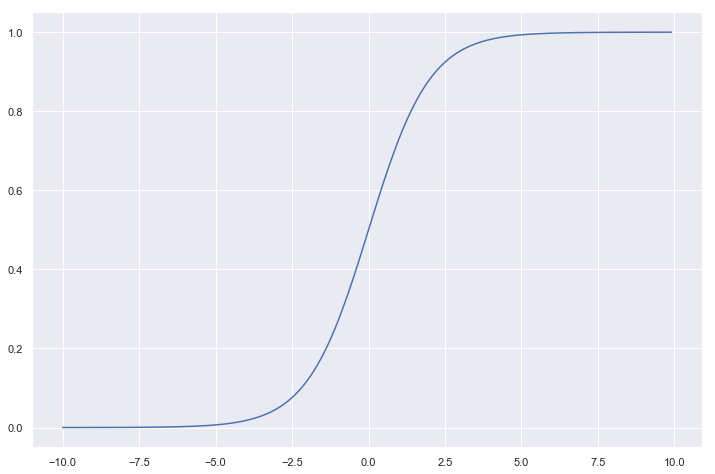

In [386]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

def sigmoid_derivative(sx):
    # sx = sigmoid(x)
    return sx * (1 - sx)

x = np.arange(-10, 10, 0.1)
y = sigmoid(x)

plt.plot(x,y)
plt.show()

## 2.2.2. Other S-Shaped Activations

There are other S-shaped activation functions that shares similar properties as the ***sigmoid***, e.g.

<!--
$\large \tanh(x) = \frac{e^x - e^{-x}} {e^x + e^{-x}}$
-->


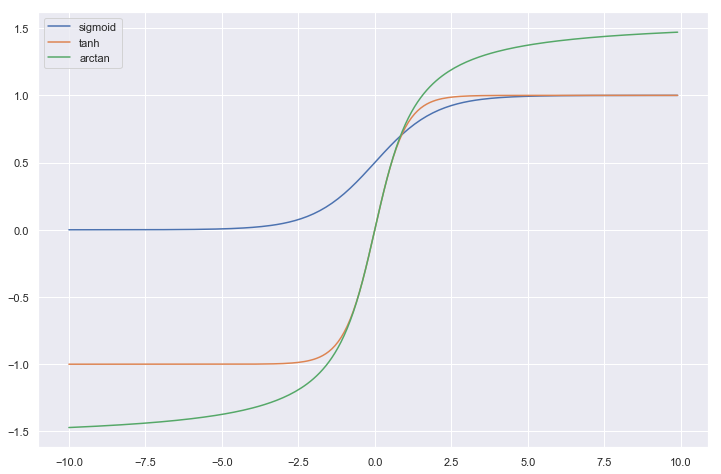

In [167]:
def tanh(x):
    # https://www.numpy.org/devdocs/reference/generated/numpy.tanh.html
    return np.tanh(x)

def arctan(x):
    # https://www.numpy.org/devdocs/reference/generated/numpy.arctan.html 
    return np.arctan(x)

x = np.arange(-10, 10, 0.1)
y1 = sigmoid(x)
y2 = tanh(x)
y3 = arctan(x)


plt.plot(x,y1, label='sigmoid')
plt.plot(x,y2, label='tanh')
plt.plot(x,y3, label='arctan')
plt.legend(loc='upper left')
plt.show()

## 2.2.3. More Activations

***Softmax*** is an activation is used quite a lot in NLP. 

$\Large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$

Because it has the special properties of ***changing values in a 1-D vector to a probabilistic interpretation***, <br>i.e. the **sum of the softmax output sums to 1.0**.


In [168]:
def softmax(x):
    return ???

x = np.arange(-10, 10, 0.1)
y1 = softmax(x)
#y2 = relu(x)

print('Sum of softmax(x) =', y1.sum())

Sum of softmax(x) = 1.0


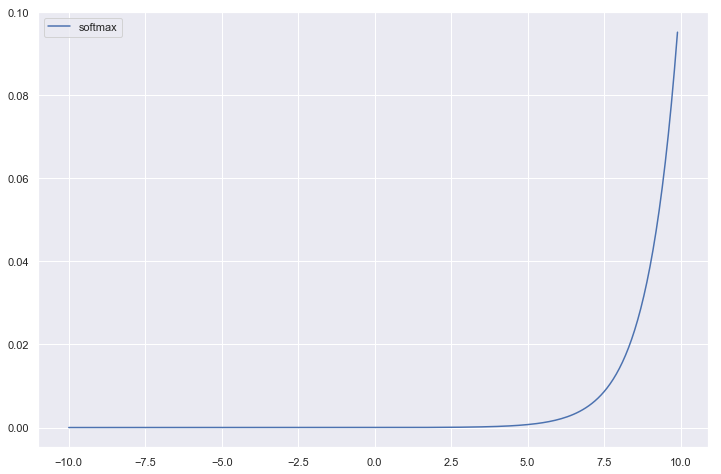

In [169]:
plt.plot(x,y1, label='softmax')
plt.legend(loc='upper left')
plt.show()

***Rectified Linear Unit (ReLU)*** is another common activation function , it simply checks whether the input is more than zero element-wise, if input is sub-zero, the ReLU output is clipped at zero:

$\large \text{ReLU}(x)= \max(0, x)$



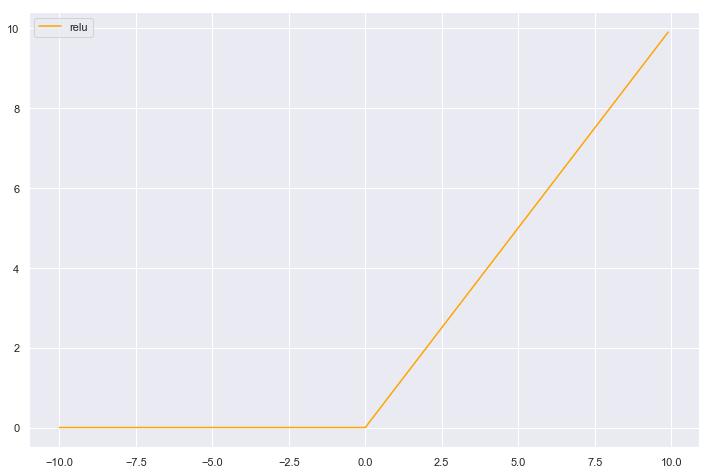

In [170]:
def relu(x):
    return x * (x > 0)

y2 = relu(x)

plt.plot(x,y2, label='relu', color='orange')
plt.legend(loc='upper left')
plt.show()

**Scaled Exponential Linear Units** is one of the many latest activation kid on the block. It's suppose to impose ***self-normalizing properties*** to the neural nets such that the training is more stable for deeper networks.

$\text{SELU}(x) = \text{scale} * (\max(0,x) + \min(0, \alpha * (\exp(x) - 1)))$

where, 

$\alpha = 1.6732632423543772848170429916717$ and <br>
$\text{scale} = 1.0507009873554804934193349852946$

On [paper](https://arxiv.org/pdf/1706.02515.pdf) (Klambauer et al. 2017) showed that it outperforms many other regularization/normalization tricks. 

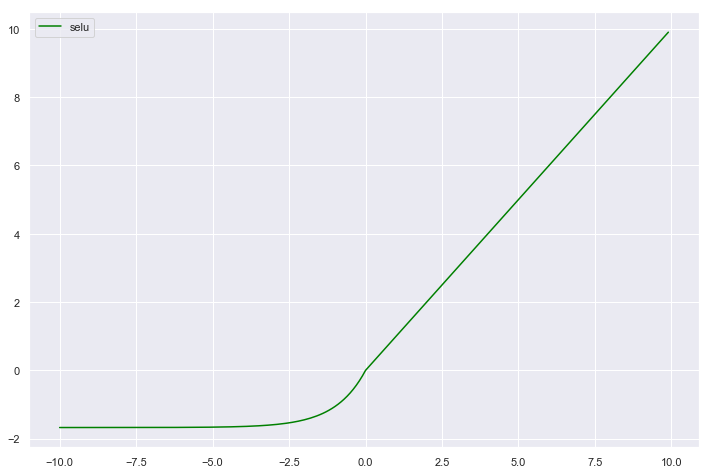

In [171]:
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return (np.maximum(???) + np.minimum(???))

y3 = selu(x)

plt.plot(x,y3, label='selu', color='green')
plt.legend(loc='upper left')
plt.show()

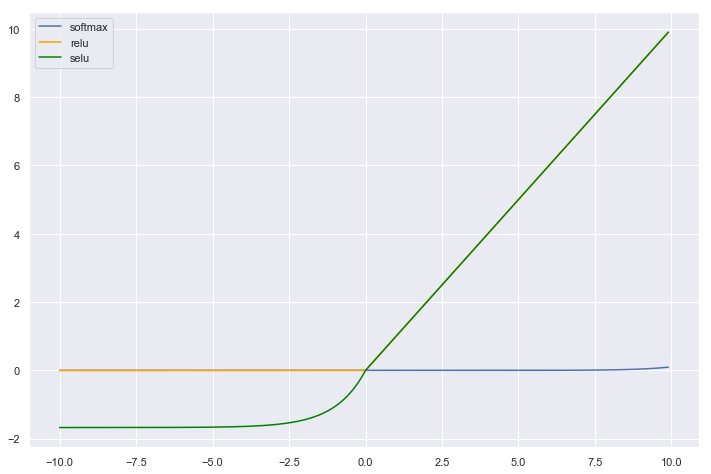

In [172]:
x = np.arange(-10, 10, 0.1)

y1 = softmax(x)
y2 = relu(x)
y3 = selu(x)

plt.plot(x,y1, label='softmax')
plt.plot(x,y2, label='relu', color='orange')
plt.plot(x,y3, label='selu', color='green')
plt.legend(loc='upper left')
plt.show()

## 2.2.4. Activation with PyTorch

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


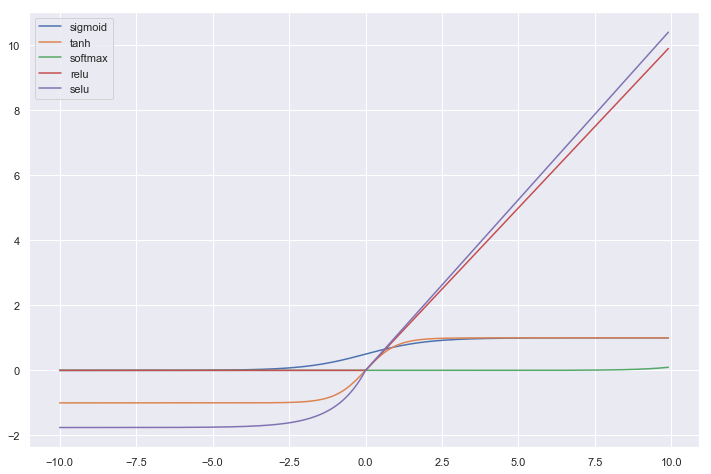

In [173]:
import torch
from torch import nn

x = torch.tensor(np.arange(-10, 10, 0.1))

# See https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity 
a1 = nn.Sigmoid()
a2 = nn.???()    # Fill in the tanh function.
a3 = nn.???() # Fill in the softmax function.
a4 = nn.???()    # Fill-in the relu func.
a5 = nn.???()    # Fill in the selu func.

# pyplot only accepts numpy arrays...
# Pardon the laziness
y1 = a1(x).numpy() 
y2 = a2(x).numpy() 
y3 = a3(x).numpy() 
y4 = a4(x).numpy() 
y5 = a5(x).numpy()
x = x.numpy()

plt.plot(x,y1, label='sigmoid')
plt.plot(x,y2, label='tanh')
plt.plot(x,y3, label='softmax')
plt.plot(x,y4, label='relu')
plt.plot(x,y5, label='selu')
plt.legend(loc='upper left')
plt.show()